### 데이콘 대회: 대구 교통사고 사고위험도 (ECLO) 예측
- https://dacon.io/competitions/official/236193/codeshare?page=1&dtype=recent&ptype=pub&keyword

- 타겟:
    - 사고위험도(ECLO)=(사망자수\*10 + 중상자수\*5 + 경상자수\*5 + 부상자수\*1) / 인명피해심각도
- 변수:
    - 사고일시+휴일+기상상태+시군구+도로형태+노면상태+사고유형 등
- 성능지표:
    - RMSLE (회귀)

- 데이터
    - train.csv (2019~2021)
        - 대구 빅데이터활용 데이터
        - 시공간 정보+사고 관련 정보
    - test.csv (2022)
        - 2022년도의 교통사고 데이터
    - country-accident.csv
        - 대구를 제외한 전국 교통사고 데이터 (2019~2021)
        - train.csv와 양식 동일
    - 기타 (보안등 정보, 어린이보호구역, 주차장 정보, CCTV 정보)

## 0. Set-Up

In [1]:
import sys
sys.path.append(r'C:\Users\KRX\Desktop\working\test\.venv\Lib\site-packages')

In [2]:
# 한글 폰트 사용을 위해서 세팅
from matplotlib import font_manager, rc

font_path = "C:/Windows/Fonts/KakaoBold.ttf"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)

## 1. V0.1 (Baseline Code)

### 1-1. 파일 읽기 및 기본 정보 확인

In [3]:
import pandas as pd
df = pd.read_csv('train.csv')
print(df.shape)
print(df.columns)
print(df.dtypes)
display(df.head(1))
display(df.describe())

(39609, 23)
Index(['ID', '사고일시', '요일', '기상상태', '시군구', '도로형태', '노면상태', '사고유형',
       '사고유형 - 세부분류', '법규위반', '가해운전자 차종', '가해운전자 성별', '가해운전자 연령', '가해운전자 상해정도',
       '피해운전자 차종', '피해운전자 성별', '피해운전자 연령', '피해운전자 상해정도', '사망자수', '중상자수',
       '경상자수', '부상자수', 'ECLO'],
      dtype='object')
ID             object
사고일시           object
요일             object
기상상태           object
시군구            object
도로형태           object
노면상태           object
사고유형           object
사고유형 - 세부분류    object
법규위반           object
가해운전자 차종       object
가해운전자 성별       object
가해운전자 연령       object
가해운전자 상해정도     object
피해운전자 차종       object
피해운전자 성별       object
피해운전자 연령       object
피해운전자 상해정도     object
사망자수            int64
중상자수            int64
경상자수            int64
부상자수            int64
ECLO            int64
dtype: object


,ID,사고일시,요일,기상상태,시군구,도로형태,노면상태,사고유형,사고유형 - 세부분류,법규위반,...,가해운전자 상해정도,피해운전자 차종,피해운전자 성별,피해운전자 연령,피해운전자 상해정도,사망자수,중상자수,경상자수,부상자수,ECLO
0,ACCIDENT_00000,2019-01-01 00,화요일,맑음,대구광역시 중구 대신동,단일로 - 기타,건조,차대사람,길가장자리구역통행중,안전운전불이행,...,상해없음,보행자,여,70세,중상,0,1,0,0,5


,사망자수,중상자수,경상자수,부상자수,ECLO
count,39609.000000,39609.000000,39609.000000,39609.000000,39609.000000
mean,0.007776,0.262365,1.070085,0.126865,4.726704
std,0.090109,0.500845,0.992034,0.394670,3.207206
min,0.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,0.000000,0.000000,0.000000,3.000000
50%,0.000000,0.000000,1.000000,0.000000,3.000000
75%,0.000000,0.000000,1.000000,0.000000,6.000000
max,2.000000,6.000000,22.000000,10.000000,74.000000


***
- Catboost 모델을 사용함
    - 범주형 변수가 많을때 사용하면 좋음 
        - 자등으로 범주형값 mean encoding, data leakage 방지
***

### 1-2. 전처리 전 원본 데이터 머신러닝 모델 돌려보기

In [4]:
# !pip install catboost
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from catboost import CatBoostRegressor
import joblib


train_df = pd.read_csv('train.csv').drop(columns='ID')
X_test = pd.read_csv('test.csv').drop(columns='ID')

X = train_df.drop(columns=['ECLO','부상자수','경상자수','중상자수','사망자수','피해운전자 상해정도','피해운전자 연령','피해운전자 차종','가해운전자 상해정도',
                           '가해운전자 연령','가해운전자 성별','가해운전자 차종','법규위반','사고유형 - 세부분류','피해운전자 성별'])
y = train_df['ECLO']

X = X.set_index('사고일시')
X_test = X_test.set_index('사고일시')
# display(X)
# display(X_test)

# 모델 학습
model = CatBoostRegressor(iterations=100, depth=5, learning_rate=0.1, random_state=99)
model.fit(X, y, verbose=0, cat_features=X.columns.tolist())

# 모델 저장
filename = 'test-model-v0.1.sav'
joblib.dump(model, filename=filename)

# 모델 추론
model = joblib.load(filename)
y_pred = model.predict(X_test)
y_pred = np.round(y_pred, 0)

submission = pd.read_csv('sample_submission.csv')
submission['ECLO'] = y_pred
submission.to_csv('my_submission-v0.1.csv', index=False)

***
v0.1 submission 결과 (RMSLE):
- Public: 0.45323, Private: 0.44948
***

***
EDA를 통해 데이터 세부정보 확인해보고 전처리 시작
***

### 1-2. EDA

#### 1-2-1. 데이터 읽기

In [5]:
X = pd.read_csv('train.csv').drop(columns='ID')

X = X.drop(columns=['부상자수','경상자수','중상자수','사망자수','피해운전자 상해정도','피해운전자 연령','피해운전자 차종','가해운전자 상해정도',
                            '가해운전자 연령','가해운전자 성별','가해운전자 차종','사고유형 - 세부분류','피해운전자 성별'])

#### 1-2-2. 년, 월, 일, 시로 분리

In [6]:
X['사고일시'] = pd.to_datetime(X['사고일시'])
X['년'] = X['사고일시'].dt.year
X['월'] = X['사고일시'].dt.month
X['일'] = X['사고일시'].dt.day
X['시'] = X['사고일시'].dt.hour
# display(X.dtypes)
# display(X.head(3))

#### 1-2-3. 년도별로 시각화

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

year: 2019
year: 2020
year: 2021


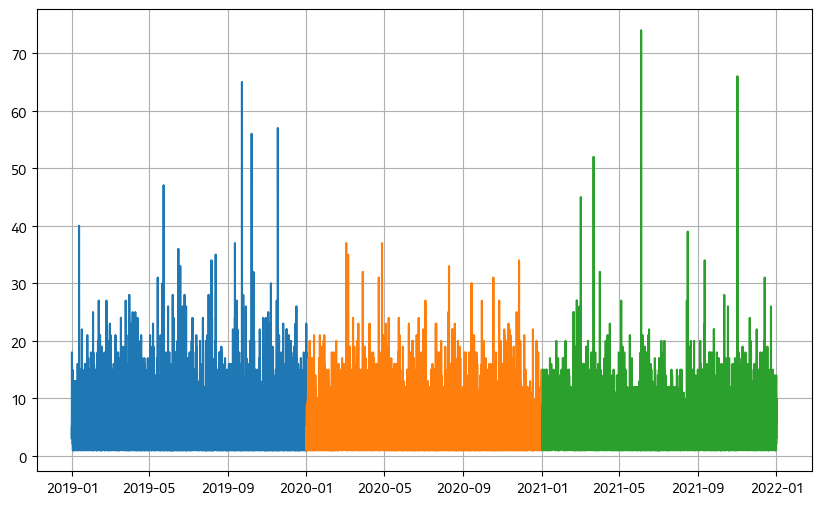

In [8]:
plt.figure(figsize=(10,6))

years = X['년'].unique().tolist()
# print(years)

for year in years:
    print('year:', year)
    temp_X = X.copy()

    temp_X = temp_X[temp_X['년']==year]
    # print(temp_X.shape, temp_y.shape)

    plt.plot(temp_X['사고일시'], temp_X['ECLO'])
    plt.grid(True)

***
특정 Seasonality 패턴이 안보임
***

#### 1-2-4. 월별로 시각화

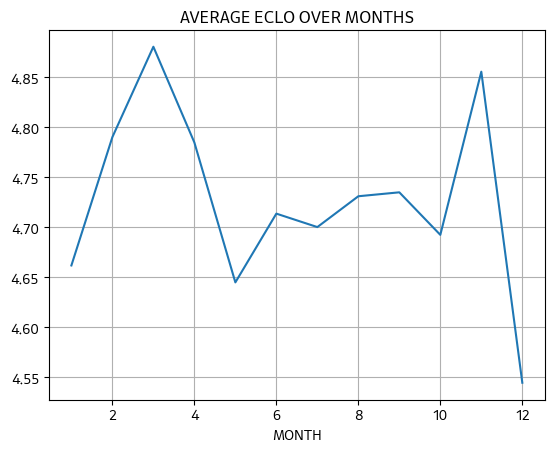

In [9]:
grouped_df = X.groupby(['월']).agg( AVG_ECLO=('ECLO','mean')).reset_index()
# display(grouped_df)
plt.plot(grouped_df['월'], grouped_df['AVG_ECLO'])
plt.title('AVERAGE ECLO OVER MONTHS')
plt.xlabel('MONTH')
plt.grid(True)

***
2월, 3월, 4월, 11월달에 ECLO 평균값이 높음; 특정 Seasonality 패턴이 안보임
***

#### 1-2-5. 시간별로 시각화

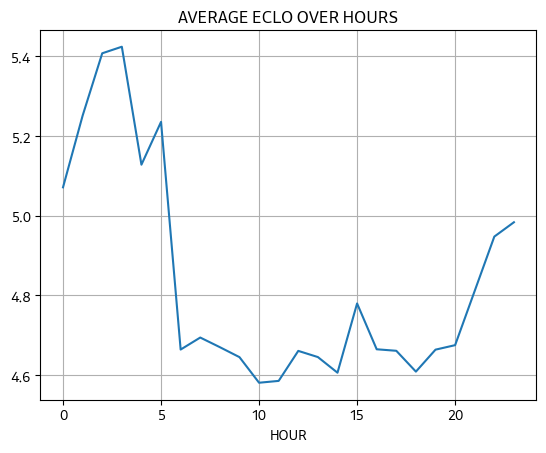

In [10]:
grouped_df = X.groupby(['시']).agg( AVG_ECLO=('ECLO','mean')).reset_index()
# display(grouped_df)
plt.plot(grouped_df['시'], grouped_df['AVG_ECLO'])
plt.title('AVERAGE ECLO OVER HOURS')
plt.xlabel('HOUR')
plt.grid(True)

***
20:00 ~ 05:00 동안 ECLO 평균값이 높음; 특정 Seasonality 패턴이 안보임
***

#### 1-2-6. 기상상태별로 시각화

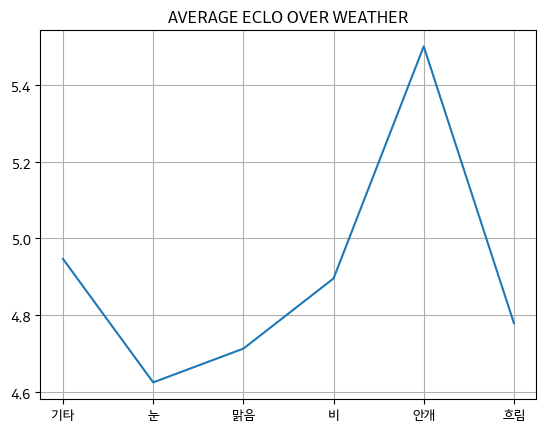

In [11]:
grouped_df = X.groupby(['기상상태']).agg( AVG_ECLO=('ECLO','mean')).reset_index()
# display(grouped_df)
plt.plot(grouped_df['기상상태'], grouped_df['AVG_ECLO'])
plt.title('AVERAGE ECLO OVER WEATHER')
plt.grid(True)

***
안개낄때 ECLO 평균값 높음
***

#### 1-2-7. 기상상태+노면상태 별로 시각화

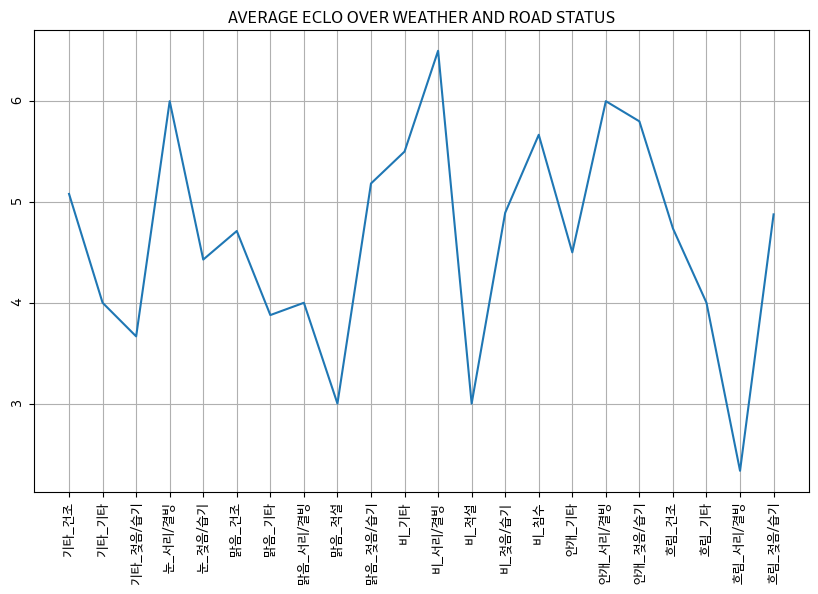

In [12]:
plt.figure(figsize=(10,6))
grouped_df = X.groupby(['기상상태','노면상태']).agg( AVG_ECLO=('ECLO','mean')).reset_index()
# display(grouped_df)
plt.plot(grouped_df['기상상태'] + '_' + grouped_df['노면상태'], grouped_df['AVG_ECLO'])
plt.title('AVERAGE ECLO OVER WEATHER AND ROAD STATUS')
plt.subplot().tick_params(rotation=90)
plt.grid(True)

***
눈-서리결빙 맑음-젖음/습기, 비-기타, 비-서리/결빙, 안개-젖음/습기 등 평균 ECLO값이 높음
***

#### 1-2-8. 3개 변수(기상상태, 노면상태, 기상노면상태) 대상으로 ECLO의 관계 시각화해보기

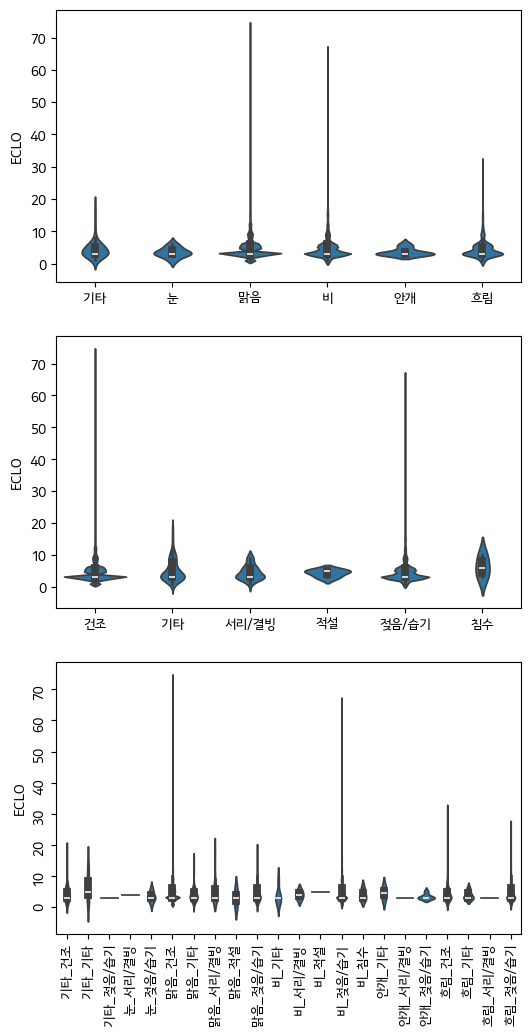

In [13]:
X['기상노면상태'] = X['기상상태'] + '_' + X['노면상태']

fig, ax = plt.subplots(nrows=3, figsize=(6,12))
sns.violinplot(x=sorted(X['기상상태']), y=X['ECLO'], ax=ax[0])
sns.violinplot(x=sorted(X['노면상태']), y=X['ECLO'], ax=ax[1])
sns.violinplot(x=sorted(X['기상노면상태']), y=X['ECLO'], ax=ax[2])
ax[2].tick_params(rotation=90)

***
- 바이올린 그래프를 보면 안개와 눈이 오는 날씨에 ECLO가 확실히 높습니다. 그런데 이상하게 <span style='text-decoration:underline'>맑음에도 ECLO가 엄청 높은 값들이 있습니다.</span>
단순히 랜덤한 이상치라고 하기는 아직 이르고, 날씨 특성만으로 ECLO를 설명하지 못하는 특성이 존재해서 값이 튀는 것 같습니다. 아마 개인별 도로특성, 운전특성, 음주운전.., 의학적변수(뇌졸증?)와 관련 있지 않을까 하는 생각이 듭니다.

- 마침 이 Trainset에 {법규 위반}이라는 Feature가 존재합니다. 날씨뿐만 아니라 뉴스나 한문철TV 같은 영상보면 법규위반으로 인해 참 사고가 많이 일어납니다.
***

### 1-3. (가설1) 법규 위반 데이터를 어느 정도 필터링하면 날씨별 ECLO의 이상치가 줄어들 것이다.
- 날씨, 도로형태 등으로 이루어진 학습 데이터에서 교통법규위반과 높은 상관성이 있는 관측치는 노이즈로 가정해보기

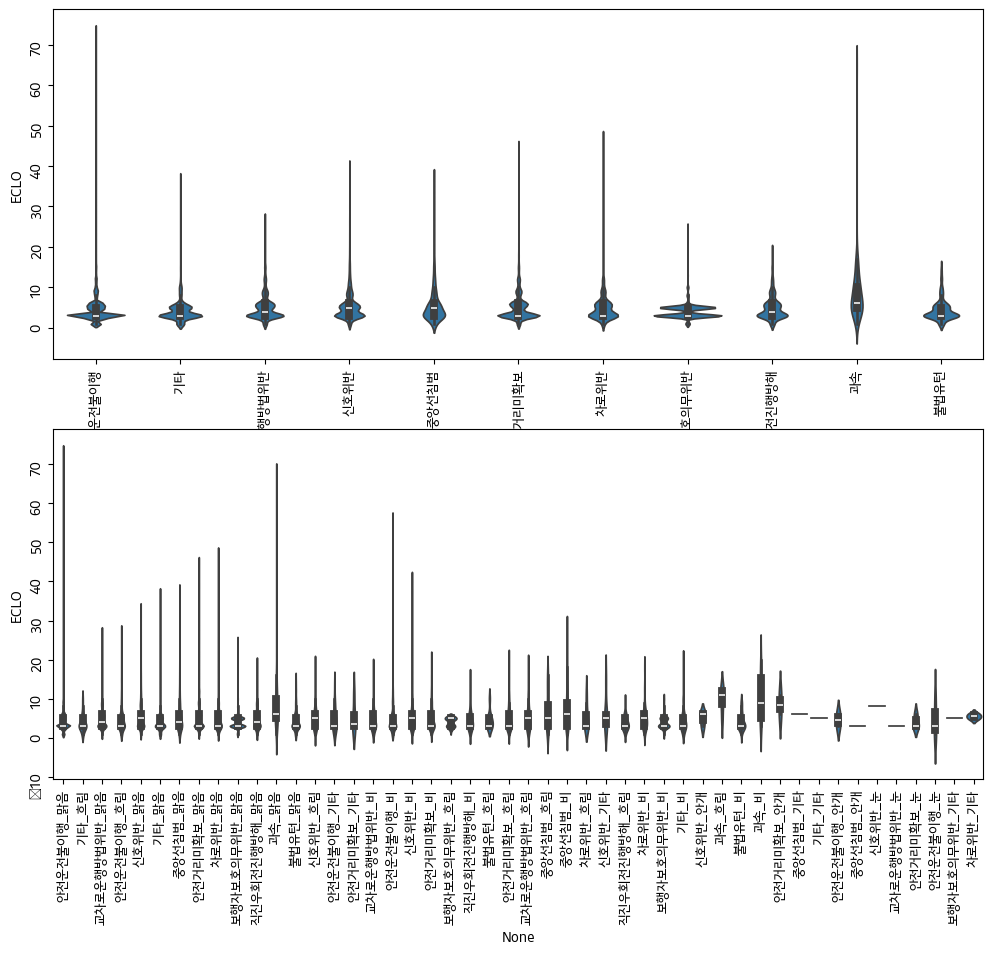

In [14]:
fig, ax = plt.subplots(nrows=2, figsize=(12,10))
sns.violinplot(x=X['법규위반'], y=X['ECLO'], ax=ax[0])
ax[0].tick_params(rotation=90)

sns.violinplot(x=X['법규위반'] + '_' + X['기상상태'], y=X['ECLO'], ax=ax[1])
ax[1].tick_params(rotation=90)

***
- 안전운전불이행, 과속과 ECLO 관계가 높은 것 같습니다.

- 더 자세히 분해해서 시각화해보니 3개 값이 딱 튀는게 보이는데 놀랍게도 맑은날씨에 ECLO 높은 이유가 안전운전불이행, 과속했기 때문입니다; 또한 비교적 비가 오는 날씨에도 ECLO가 높은 이유은 안전운전불이행으로 나타납니다.
***

#### 1-3-1. 이 세 개 CLASS(안전운전불이행_맑음, 과속_맑음, 안전운전불이행_비)을 이상치로 설정하고 제거

In [15]:
original_nrows = X.shape[0]
X['법규위반기상상태'] = X['법규위반'] + '_' + X['기상상태']

X_filtered = X.copy()

X_filtered = X_filtered[~(X_filtered['법규위반기상상태'].isin({'안전운전불이행_맑음', '과속_맑음', '안전운전불이행_비'}))]
print('총', original_nrows, '행 에서', original_nrows - X_filtered.shape[0], '행이 제거 됐습니다')

총 39609 행 에서 21556 행이 제거 됐습니다


***
21556 행이 제거. 상당히 많은 행이 제거
***

#### 1-3-2. 3개 변수 대상으로 ECLO의 관계 시각화해보기 (반복)

Text(0.5, 1.0, '기상노면상태 이상치제거')

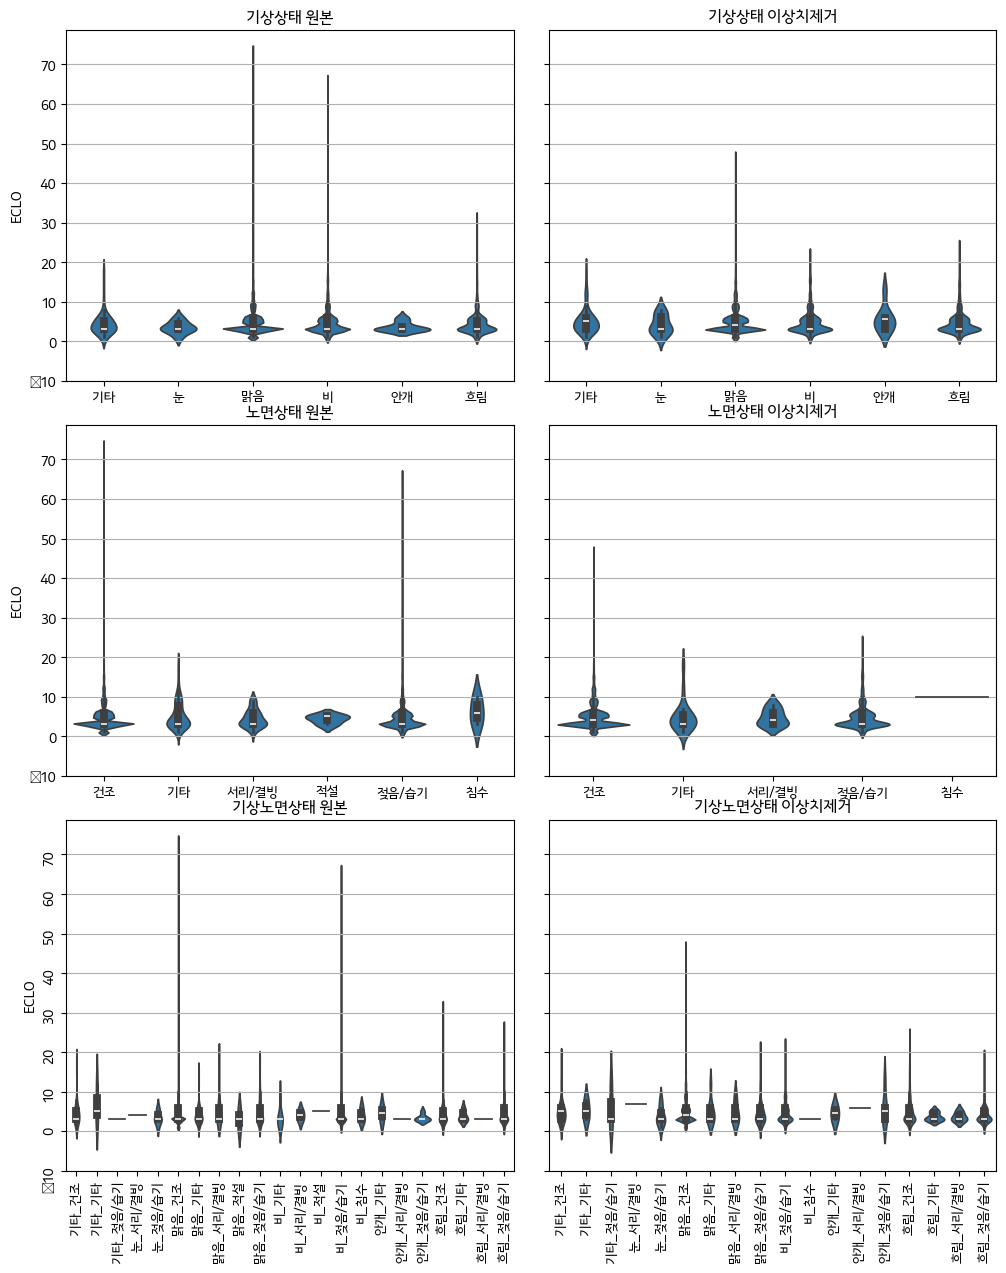

In [16]:
plt.rcParams['axes.grid'] = True
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(10,12), sharey=True)
fig.tight_layout()

sns.violinplot(x=sorted(X['기상상태']), y=X['ECLO'], ax=ax[0,0])
sns.violinplot(x=sorted(X_filtered['기상상태']), y=X_filtered['ECLO'], ax=ax[0,1])
sns.violinplot(x=sorted(X['노면상태']), y=X['ECLO'], ax=ax[1,0])
sns.violinplot(x=sorted(X_filtered['노면상태']), y=X_filtered['ECLO'], ax=ax[1,1])
sns.violinplot(x=sorted(X['기상노면상태']), y=X['ECLO'], ax=ax[2,0])
sns.violinplot(x=sorted(X_filtered['기상노면상태']), y=X_filtered['ECLO'], ax=ax[2,1])
ax[2,0].tick_params(rotation=90)
ax[2,1].tick_params(rotation=90)

ax[0,0].set_yticks(np.arange(-10,80,10))
ax[0,1].set_yticks(np.arange(-10,80,10))
ax[1,0].set_yticks(np.arange(-10,80,10))
ax[1,1].set_yticks(np.arange(-10,80,10))
ax[2,0].set_yticks(np.arange(-10,80,10))
ax[2,1].set_yticks(np.arange(-10,80,10))

ax[0,0].set_title('기상상태 원본')
ax[0,1].set_title('기상상태 이상치제거')
ax[1,0].set_title('노면상태 원본')
ax[1,1].set_title('노면상태 이상치제거')
ax[2,0].set_title('기상노면상태 원본')
ax[2,1].set_title('기상노면상태 이상치제거')

#### 1-3-3. 타겟인 ECLO만 제외하고 원본 데이터 피쳐와 동일하게 매핑시키기

In [17]:
train_df = pd.read_csv('train.csv').drop(columns='ID')

X = train_df.drop(columns=['부상자수','경상자수','중상자수','사망자수','피해운전자 상해정도','피해운전자 연령','피해운전자 차종','가해운전자 상해정도',
                           '가해운전자 연령','가해운전자 성별','가해운전자 차종','법규위반','사고유형 - 세부분류','피해운전자 성별'])

X_filtered = X_filtered[X.columns]
display(X_filtered)

,사고일시,요일,기상상태,시군구,도로형태,노면상태,사고유형,ECLO
1,2019-01-01 00:00:00,화요일,흐림,대구광역시 달서구 감삼동,단일로 - 기타,건조,차대사람,3
6,2019-01-01 05:00:00,화요일,맑음,대구광역시 수성구 지산동,교차로 - 교차로안,건조,차대차,18
7,2019-01-01 06:00:00,화요일,흐림,대구광역시 달서구 상인동,단일로 - 기타,건조,차대차,3
9,2019-01-01 10:00:00,화요일,맑음,대구광역시 동구 지묘동,단일로 - 터널,건조,차대차,9
10,2019-01-01 11:00:00,화요일,맑음,대구광역시 서구 평리동,단일로 - 기타,건조,차대차,5
...,...,...,...,...,...,...,...,...
39601,2021-12-31 18:00:00,금요일,맑음,대구광역시 서구 평리동,교차로 - 교차로안,건조,차대차,6
39602,2021-12-31 18:00:00,금요일,흐림,대구광역시 달서구 이곡동,교차로 - 교차로부근,건조,차대사람,3
39604,2021-12-31 19:00:00,금요일,맑음,대구광역시 수성구 수성동3가,교차로 - 교차로안,건조,차대차,3
39605,2021-12-31 19:00:00,금요일,맑음,대구광역시 달서구 상인동,단일로 - 기타,건조,차대차,3


#### 1-3-4. 이상치 제거한 데이터 파일 저장

In [18]:
X_filtered.to_csv('train-v0.2.csv', index=False)

***
- 이상치 제거한 학습데이터(train-v0.2)로 다시 동일 머신러닝 모델에 학습해보겠습니다.
- 과적합 우려로 테스트 데이터는 원본 데이터로 지정
***

## V0.2

In [19]:
# !pip install catboost
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from catboost import CatBoostRegressor
import joblib

train_df = pd.read_csv('train.csv').drop(columns='ID')
X_test = pd.read_csv('test.csv').drop(columns='ID')

X = train_df.drop(columns=['ECLO','부상자수','경상자수','중상자수','사망자수','피해운전자 상해정도','피해운전자 연령','피해운전자 차종','가해운전자 상해정도',
                           '가해운전자 연령','가해운전자 성별','가해운전자 차종','법규위반','사고유형 - 세부분류','피해운전자 성별'])
y = train_df['ECLO']

X = X.set_index('사고일시')
X_test = X_test.set_index('사고일시')
# display(X)
# display(X_test)

# 모델 학습
model = CatBoostRegressor(iterations=100, depth=5, learning_rate=0.1, random_state=99)
model.fit(X, y, verbose=0, cat_features=X.columns.tolist())

# 모델 저장
filename = 'test-model-v0.1.sav'
joblib.dump(model, filename=filename)

# 모델 추론
model = joblib.load(filename)
y_pred = model.predict(X_test)
y_pred = np.round(y_pred, 0)

submission = pd.read_csv('sample_submission.csv')
submission['ECLO'] = y_pred
submission.to_csv('my_submission-v0.1.csv', index=False)


train_df = pd.read_csv('train-v0.2.csv')
X_test = pd.read_csv('test.csv').drop(columns='ID')

X = train_df
y = train_df['ECLO']
del X['ECLO']

X = X.set_index('사고일시')
X_test = X_test.set_index('사고일시')

# 불필요한 피쳐 제거 (지역 관련 피쳐)
del X['시군구']
del X_test['시군구']

display(X)
display(X_test)

# 모델 학습
model = CatBoostRegressor(iterations=100, depth=5, learning_rate=0.1, random_state=99)
model.fit(X, y, verbose=0, cat_features=X.columns.tolist())

# 모델 저장
filename = 'test-model-v0.2.sav'
joblib.dump(model, filename=filename)

# 모델 추론
model = joblib.load(filename)
y_pred = model.predict(X_test)
y_pred = np.round(y_pred, 0)

submission = pd.read_csv('sample_submission.csv')
submission['ECLO'] = y_pred
submission.to_csv('my_submission-v0.2.csv', index=False)

,요일,기상상태,도로형태,노면상태,사고유형
사고일시,,,,,
2019-01-01 00:00:00,화요일,흐림,단일로 - 기타,건조,차대사람
2019-01-01 05:00:00,화요일,맑음,교차로 - 교차로안,건조,차대차
2019-01-01 06:00:00,화요일,흐림,단일로 - 기타,건조,차대차
2019-01-01 10:00:00,화요일,맑음,단일로 - 터널,건조,차대차
2019-01-01 11:00:00,화요일,맑음,단일로 - 기타,건조,차대차
...,...,...,...,...,...
2021-12-31 18:00:00,금요일,맑음,교차로 - 교차로안,건조,차대차
2021-12-31 18:00:00,금요일,흐림,교차로 - 교차로부근,건조,차대사람
2021-12-31 19:00:00,금요일,맑음,교차로 - 교차로안,건조,차대차


,요일,기상상태,도로형태,노면상태,사고유형
사고일시,,,,,
2022-01-01 01,토요일,맑음,교차로 - 교차로안,건조,차대사람
2022-01-01 01,토요일,맑음,단일로 - 기타,건조,차대사람
2022-01-01 04,토요일,맑음,교차로 - 교차로안,건조,차대차
2022-01-01 04,토요일,맑음,단일로 - 기타,건조,차대차
2022-01-01 06,토요일,맑음,교차로 - 교차로안,건조,차대차
...,...,...,...,...,...
2022-12-31 18,토요일,맑음,단일로 - 터널,건조,차대차
2022-12-31 18,토요일,맑음,단일로 - 기타,건조,차대차
2022-12-31 20,토요일,맑음,단일로 - 기타,건조,차대차


***
v0.2 submission 결과 (RMSLE):
- Public: 0.45425, Private: 0.45645
***

***
- 과적합 때문에 성능점수가 낮아졌는지 확인
    - 이상치(안전운전불이행_맑음, 과속_맑음, 안전운전불이행_비) 제거 비율을 조정해서 모델 학습시켜보기
***

## V0.21 (이상치 제거 비율 조정)

In [20]:
# !pip install catboost
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from catboost import CatBoostRegressor
import joblib

train_df = pd.read_csv('train.csv').drop(columns='ID')
X_test = pd.read_csv('test.csv').drop(columns='ID')

X = train_df.drop(columns=['ECLO','부상자수','경상자수','중상자수','사망자수','피해운전자 상해정도','피해운전자 연령','피해운전자 차종','가해운전자 상해정도',
                           '가해운전자 연령','가해운전자 성별','가해운전자 차종','법규위반','사고유형 - 세부분류','피해운전자 성별'])
y = train_df['ECLO']

X = X.set_index('사고일시')
X_test = X_test.set_index('사고일시')
# display(X)
# display(X_test)

# 모델 학습
model = CatBoostRegressor(iterations=100, depth=5, learning_rate=0.1, random_state=99)
model.fit(X, y, verbose=0, cat_features=X.columns.tolist())

# 모델 저장
filename = 'test-model-v0.1.sav'
joblib.dump(model, filename=filename)

# 모델 추론
model = joblib.load(filename)
y_pred = model.predict(X_test)
y_pred = np.round(y_pred, 0)

submission = pd.read_csv('sample_submission.csv')
submission['ECLO'] = y_pred
submission.to_csv('my_submission-v0.1.csv', index=False)

X = pd.read_csv('train.csv').drop(columns='ID')

X = X.drop(columns=['부상자수','경상자수','중상자수','사망자수','피해운전자 상해정도','피해운전자 연령','피해운전자 차종','가해운전자 상해정도',
                           '가해운전자 연령','가해운전자 성별','가해운전자 차종','사고유형 - 세부분류','피해운전자 성별'])

# X = X.set_index('사고일시')

# 년, 월, 일, 시로 분리
temp_X = X

temp_X['사고일시'] = pd.to_datetime(temp_X['사고일시'])
temp_X['년'] = temp_X['사고일시'].dt.year
temp_X['월'] = temp_X['사고일시'].dt.month
temp_X['일'] = temp_X['사고일시'].dt.day
temp_X['시'] = temp_X['사고일시'].dt.hour

temp_X['기상노면상태'] = temp_X['기상상태'] + '_' + temp_X['노면상태']

# 이 세 개 CLASS(안전운전불이행_맑음, 과속_맑음, 안전운전불이행_비)을 이상치로 설정하고 제거
temp_X['법규위반기상상태'] = temp_X['법규위반'] + '_' + temp_X['기상상태']

sample_df = temp_X.copy()
sample_df = sample_df[sample_df['법규위반기상상태'].isin({'안전운전불이행_맑음', '과속_맑음', '안전운전불이행_비'})]

# 이상치 제거 비율을 조정 [10%,20%,30%,40%,50%]
# 전체 이상치의 10%만 제거, 20%, 30%, 40%, 50%
fracs = [0.1,0.2,0.3,0.4,0.5]

for frac in fracs:
    print('-'*120)

    output_version = 'v0.21' + '_' + str(frac)

    sample_ids = sample_df.sample(frac=frac, replace=False).index

    temp_X_filtered = temp_X.copy()
    temp_X_filtered = temp_X_filtered[~(temp_X_filtered.index.isin(sample_ids))]

    # display(temp_X_filtered)

    print(original_nrows - temp_X_filtered.shape[0], '행이 제거 됐습니다')

    # 타겟인 ECLO만 제외하고 원본 데이터 피쳐와 동일하게 매핑시키기
    train_df = pd.read_csv('train.csv').drop(columns='ID')

    X = train_df.drop(columns=['부상자수','경상자수','중상자수','사망자수','피해운전자 상해정도','피해운전자 연령','피해운전자 차종','가해운전자 상해정도',
                            '가해운전자 연령','가해운전자 성별','가해운전자 차종','법규위반','사고유형 - 세부분류','피해운전자 성별'])

    temp_X_filtered = temp_X_filtered[X.columns]
    # display(temp_X_filtered)

    # 이상치 제거한 데이터를 파일저장하고 머신러닝 모델에 적용해보기
    temp_X_filtered.to_csv(f'train-{output_version}.csv', index=False)

    ### ------------------------------------- 머신러닝 모델 ------------------------------------- ###
    # !pip install catboost
    import warnings
    warnings.filterwarnings('ignore')
    import pandas as pd
    import numpy as np
    from catboost import CatBoostRegressor, Pool
    from sklearn.preprocessing import LabelEncoder
    from sklearn.model_selection import cross_validate
    from sklearn.metrics import mean_squared_log_error
    import joblib

    train_df = pd.read_csv(f'train-{output_version}.csv')
    X_test = pd.read_csv('test.csv').drop(columns='ID')

    X = train_df
    y = train_df['ECLO']
    del X['ECLO']

    X = X.set_index('사고일시')
    X_test = X_test.set_index('사고일시')

    # 불필요한 피쳐 제거 (지역 관련 피쳐)
    del X['시군구']
    del X_test['시군구']

    display(X.shape)
    display(X_test.shape)

    # 모델 학습
    model = CatBoostRegressor(iterations=100, depth=5, learning_rate=0.1, random_state=99)
    model.fit(X, y, verbose=0, cat_features=X.columns.tolist())

    # 모델 저장
    filename = f'test-model-{output_version}.sav'
    joblib.dump(model, filename=filename)

    # 모델 추론
    model = joblib.load(filename)
    y_pred = model.predict(X_test)
    y_pred = np.round(y_pred, 0)

    submission = pd.read_csv('sample_submission.csv')
    submission['ECLO'] = y_pred
    submission.to_csv(f'my_submission-{output_version}.csv', index=False)


------------------------------------------------------------------------------------------------------------------------
2156 행이 제거 됐습니다


(37453, 5)

(10963, 5)

------------------------------------------------------------------------------------------------------------------------
4311 행이 제거 됐습니다


(35298, 5)

(10963, 5)

------------------------------------------------------------------------------------------------------------------------
6467 행이 제거 됐습니다


(33142, 5)

(10963, 5)

------------------------------------------------------------------------------------------------------------------------
8622 행이 제거 됐습니다


(30987, 5)

(10963, 5)

------------------------------------------------------------------------------------------------------------------------
10778 행이 제거 됐습니다


(28831, 5)

(10963, 5)

***
v0.21 submission 결과 (RMSLE):
- 이상치 10% 제거할 경우
    - Public: 0.44946, Private: 0.45272
- 이상치 20% 제거할 경우
    - Public: 0.44944, Private: 0.45238
- 이상치 30% 제거할 경우
    - Public: 0.44970, Private: 0.45327
- 이상치 40% 제거할 경우
    - Public: 0.45004, Private: 0.45315
- 이상치 50% 제거할 경우
    - Public: 0.45166, Private: 0.45483

- 이상치 제거 비율 30% 이상부터 오차가 다시 커짐

- <strong>최종결과: 이상치 20% 제거할 경우 (Public: 0.44944, Private: 0.45238) 가 실제-예측 오차가 제일 적게 나옴
    - 이상치 20% 선택</strong>
***